# 1. Import Packages

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
from collections import Counter
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import datetime as dt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.models import Sequential
import warnings

# 2. Load Files

In [2]:
train = pd.read_csv("../input/competitive-data-science-predict-future-sales/sales_train.csv")
test=pd.read_csv("../input/competitive-data-science-predict-future-sales/test.csv")
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


**Looking at the data. There is no daily transactions of the items. so, we need to focus on monthly sales**

In [3]:
#Shape
train.shape, test.shape

((2935849, 6), (214200, 3))

In [4]:
#dtypes
train.dtypes

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

# 3. EDA Analysis

In [5]:
#Train Statistics
train.describe().style.background_gradient()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2935849.000000,2935849.000000,2935849.000000,2935849.000000,2935849.000000
mean,14.569911,33.001728,10197.227057,890.853233,1.242641
std,9.422988,16.226973,6324.297354,1729.799631,2.618834
min,0.000000,0.000000,0.000000,-1.000000,-22.000000
25%,7.000000,22.000000,4476.000000,249.000000,1.000000
50%,14.000000,31.000000,9343.000000,399.000000,1.000000
75%,23.000000,47.000000,15684.000000,999.000000,1.000000
max,33.000000,59.000000,22169.000000,307980.000000,2169.000000


In [6]:
#Test Statistics
test.describe().style.background_gradient()

,ID,shop_id,item_id
count,214200.000000,214200.000000,214200.000000
mean,107099.500000,31.642857,11019.398627
std,61834.358168,17.561933,6252.644590
min,0.000000,2.000000,30.000000
25%,53549.750000,16.000000,5381.500000
50%,107099.500000,34.500000,11203.000000
75%,160649.250000,47.000000,16071.500000
max,214199.000000,59.000000,22167.000000


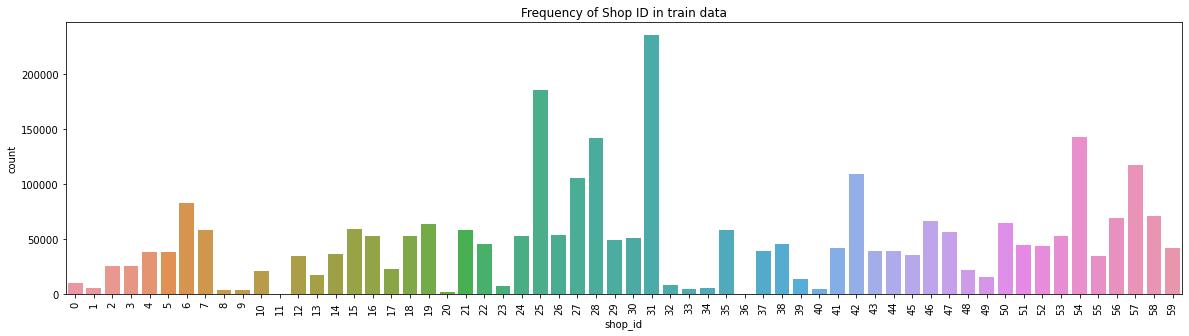

In [7]:
#Frequency of Shop ID in train
plt.figure(figsize=(20,5))
ax=sbn.countplot(data=train, x='shop_id')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title("Frequency of Shop ID in train data")
plt.show()

**This shows few of the shops have daily transaction(sold/cancelled) of the items over the period January 2013 to october 2015**

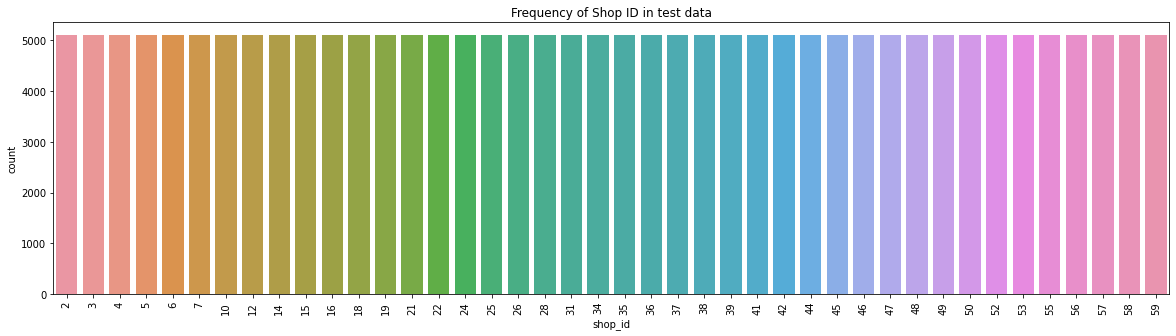

In [8]:
#Frequency of Shop ID in test
plt.figure(figsize=(20,5))
ax=sbn.countplot(data=test, x='shop_id')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title("Frequency of Shop ID in test data")
plt.show()

**Some shops didn't sell the mentioned items in November 2015**

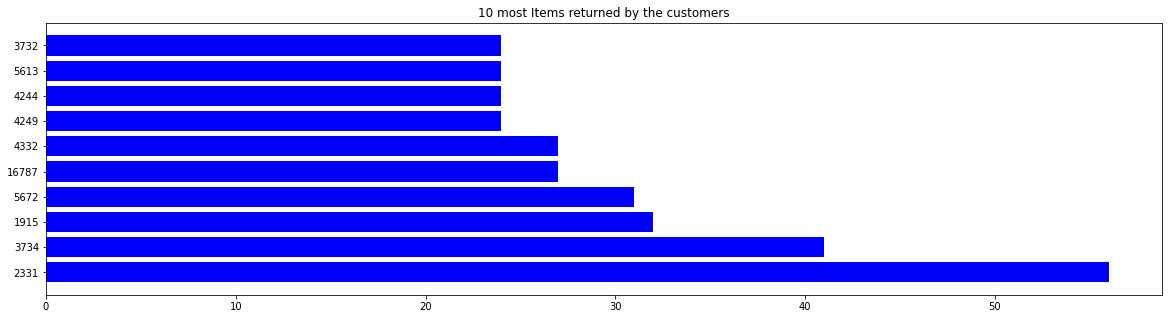

In [9]:
#10 most items returned by customers
counter = pd.DataFrame(Counter(train[train['item_cnt_day']<0]['item_id']).most_common(10))
counter.columns=['item_id', 'Counts']
counter['item_id']=counter['item_id'].astype('str')
plt.figure(figsize=(20,5))
plt.barh(data=counter, y='item_id', width='Counts', color='blue')
plt.title("10 most Items returned by the customers")
plt.show()

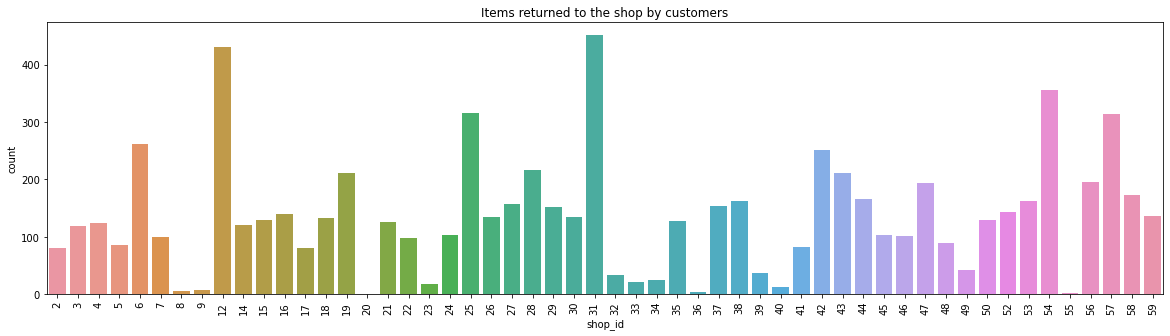

In [10]:
#Items returned to the shop by customers
plt.figure(figsize=(20,5))
ax=sbn.countplot(data=train[train['item_cnt_day']<0], x='shop_id')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title("Items returned to the shop by customers")
plt.show()

**Items were returned to most of the shops**

In [11]:
#Total number of items sold/cancelled in the perood Jan 2013 to Oct 2015
len(train.item_id.unique())

21807

In [12]:
#Total number of items sold/cancelled in the Novemeber 2015
len(test.item_id.unique())

5100

In [13]:
#List of Items sold/cancelled in Novemeber 2015 but not sold/cancelled in the perood Jan 2013 to Oct 2015 
columns = set(test['item_id'])-set(train['item_id'])
columns

{83,
 140,
 168,
 173,
 204,
 237,
 249,
 254,
 302,
 402,
 428,
 430,
 454,
 480,
 566,
 639,
 640,
 762,
 892,
 900,
 907,
 1184,
 1193,
 1246,
 1252,
 1253,
 1254,
 1284,
 1386,
 1394,
 1434,
 1436,
 1437,
 1574,
 1575,
 1577,
 1580,
 1585,
 1679,
 1683,
 1732,
 1864,
 1867,
 1884,
 1885,
 2322,
 2323,
 2324,
 2325,
 2326,
 2327,
 2328,
 2420,
 2426,
 2427,
 2428,
 2434,
 2569,
 2722,
 2966,
 3022,
 3023,
 3271,
 3272,
 3273,
 3282,
 3284,
 3338,
 3349,
 3354,
 3405,
 3407,
 3408,
 3538,
 3571,
 3579,
 3604,
 3627,
 3760,
 3867,
 3908,
 3984,
 4060,
 4156,
 4310,
 4318,
 4412,
 4642,
 4925,
 5025,
 5064,
 5121,
 5248,
 5268,
 5269,
 5320,
 5321,
 5322,
 5441,
 5541,
 5569,
 5667,
 5721,
 5722,
 5812,
 5826,
 5843,
 5844,
 5961,
 5963,
 6152,
 6153,
 6169,
 6259,
 6335,
 6439,
 6519,
 6520,
 6521,
 6522,
 6523,
 6524,
 6525,
 6526,
 6527,
 6528,
 6529,
 6530,
 6531,
 6532,
 6533,
 6645,
 6729,
 6730,
 6731,
 6732,
 6733,
 6734,
 6742,
 6743,
 6863,
 6891,
 6903,
 6996,
 7094,
 7124,


# 4. Data Preparation

In [14]:
#Remove unwanted data
test_data = test.copy(deep=True)
train=train.drop(['date_block_num','item_price'], axis=1)
test=test.drop(['ID'], axis=1)
#Since we have to do prediction on Novmber Sales so I assigned date_block_num as 34
train.shape, test.shape

((2935849, 4), (214200, 2))

In [15]:
#Missing Values in train data
train.isna().sum()

date            0
shop_id         0
item_id         0
item_cnt_day    0
dtype: int64

In [16]:
#Missing Values in test data
test.isna().sum()

shop_id    0
item_id    0
dtype: int64

In [17]:
#type cast the date and change the date into monthlywise
def get_month(x):
    return dt.datetime(x.year, x.month, 1)
train['date']=[x.replace('.', '-') for x in train['date']]
train['date']=pd.to_datetime(train['date'], format='%d-%m-%Y')
train['date']=train['date'].apply(get_month)
train.head()

,date,shop_id,item_id,item_cnt_day
0,2013-01-01,59,22154,1.0
1,2013-01-01,25,2552,1.0
2,2013-01-01,25,2552,-1.0
3,2013-01-01,25,2554,1.0
4,2013-01-01,25,2555,1.0


In [18]:
#group by 'date_block_num', 'shop_id', 'item_id'
train=train.groupby(['date', 'shop_id', 'item_id']).agg({'item_cnt_day': 'sum'})
train.reset_index(inplace=True)

In [19]:
#Merge two columns
train['shop_item']=train['shop_id'].astype('str')+'_'+train['item_id'].astype('str')
test['shop_item']=test['shop_id'].astype('str')+'_'+test['item_id'].astype('str')
train = train.drop(['shop_id', 'item_id'], axis=1)
test = test.drop(['shop_id', 'item_id'], axis=1)
train.head()

,date,item_cnt_day,shop_item
0,2013-01-01,6.0,0_32
1,2013-01-01,3.0,0_33
2,2013-01-01,1.0,0_35
3,2013-01-01,1.0,0_43
4,2013-01-01,2.0,0_51


In [20]:
data = train.merge(test, how='outer', on='shop_item').fillna(0)

In [21]:
warnings.filterwarnings('ignore')
data.date[data.date==0]=pd.to_datetime('2015-10-01')
data

,date,item_cnt_day,shop_item
0,2013-01-01 00:00:00,6.0,0_32
1,2013-02-01 00:00:00,10.0,0_32
2,2013-01-01 00:00:00,3.0,0_33
3,2013-02-01 00:00:00,3.0,0_33
4,2013-01-01 00:00:00,1.0,0_35
...,...,...,...
1711915,2015-10-01 00:00:00,0.0,45_9500
1711916,2015-10-01 00:00:00,0.0,45_16007
1711917,2015-10-01 00:00:00,0.0,45_18027
1711918,2015-10-01 00:00:00,0.0,45_16188


In [22]:
data = data.pivot_table(index='date', columns='shop_item').item_cnt_day.fillna(0)
data

shop_item,0_1000,0_10004,0_1001,0_10012,0_1002,0_1003,0_10033,0_10038,0_10039,0_1004,...,9_9422,9_9423,9_9424,9_9425,9_9443,9_9469,9_9532,9_9782,9_9785,9_9904
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,5.0,0.0,2.0,1.0,2.0,2.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-02-01,4.0,1.0,0.0,2.0,0.0,0.0,1.0,1.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-06-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-07-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-08-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-09-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
#Select only test shop and item
data=data.loc[:,test['shop_item']]
data

shop_item,5_5037,5_5320,5_5233,5_5232,5_5268,5_5039,5_5041,5_5046,5_5319,5_5003,...,45_3280,45_4393,45_4352,45_18049,45_18027,45_18454,45_16188,45_15757,45_19648,45_969
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2013-02-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-06-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-07-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-08-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-09-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
n_past=1
n_future=1
trainX=[]
trainY=[]
testX=[]
for i in range(n_past, len(np.array(data)) - n_future +1):
    trainY.append(np.array(data)[i + n_future - 1:i + n_future])
    trainX.append(np.array(data)[(i - n_past):i, 0:np.array(data).shape[1]])
trainX, trainY = np.array(trainX), np.array(trainY)
trainX.shape, trainY.shape

((33, 1, 214200), (33, 1, 214200))

# 4. Model Building

In [25]:
model = Sequential()
model.add(LSTM(16, activation='tanh', input_shape=(trainX.shape[1], trainX.shape[2]), batch_input_shape=(1, trainX.shape[1], trainX.shape[2]),return_sequences=True, stateful=True))
model.add(LSTM(16, activation='tanh', return_sequences=False, stateful=False))
model.add(Dense(16, activation='tanh'))
model.add(Dense(trainY.shape[2], activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, 1, 16)                13709888  
_________________________________________________________________
lstm_1 (LSTM)                (1, 16)                   2112      
_________________________________________________________________
dense (Dense)                (1, 16)                   272       
_________________________________________________________________
dense_1 (Dense)              (1, 214200)               3641400   
Total params: 17,353,672
Trainable params: 17,353,672
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.compile(loss='huber_loss', optimizer=Adam(learning_rate=0.00005, clipnorm=1.0), metrics='mse')

In [27]:
history = model.fit(trainX, trainY, epochs=2000, batch_size=1, validation_split=0.10, verbose=1)

Epoch 1/2000
29/29 [==============================] - 6s 32ms/step - loss: 0.1808 - mse: 11.3732 - val_loss: 0.2082 - val_mse: 11.6423
Epoch 2/2000
29/29 [==============================] - 0s 9ms/step - loss: 0.1808 - mse: 11.3726 - val_loss: 0.2081 - val_mse: 11.6418
Epoch 3/2000
29/29 [==============================] - 0s 9ms/step - loss: 0.1806 - mse: 11.3715 - val_loss: 0.2079 - val_mse: 11.6409
Epoch 4/2000
29/29 [==============================] - 0s 9ms/step - loss: 0.1804 - mse: 11.3701 - val_loss: 0.2077 - val_mse: 11.6399
Epoch 5/2000
29/29 [==============================] - 0s 9ms/step - loss: 0.1802 - mse: 11.3686 - val_loss: 0.2075 - val_mse: 11.6388
Epoch 6/2000
29/29 [==============================] - 0s 9ms/step - loss: 0.1800 - mse: 11.3668 - val_loss: 0.2072 - val_mse: 11.6374
Epoch 7/2000
29/29 [==============================] - 0s 9ms/step - loss: 0.1797 - mse: 11.3647 - val_loss: 0.2069 - val_mse: 11.6358
Epoch 8/2000
29/29 [==============================] - 0s 9ms/

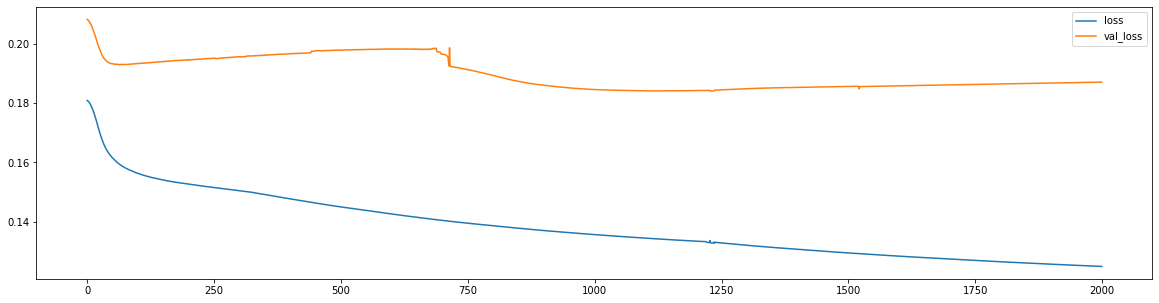

In [28]:
#Plot the loss curve
plt.figure(figsize=(20,5))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

# 6. Submission to Kaggle

In [29]:
test_pr=np.array(data.loc['2015-10-01', :]).reshape(1,1,data.shape[1])

In [30]:
pred = model.predict(test_pr, batch_size=1)

In [31]:
#Prediction on test set
test_data['item_cnt_month'] = pred.reshape(trainY.shape[2])
test_data['item_cnt_month']

0         0.364845
1        -0.001653
2         0.696408
3         0.001221
4        -0.001818
            ...   
214195    0.224355
214196   -0.001673
214197    0.133313
214198    0.001148
214199   -0.052007
Name: item_cnt_month, Length: 214200, dtype: float32

In [32]:
test_data[['ID', 'item_cnt_month']].to_csv("submission.csv", index=False)